# Data Exploration and Visualization of CitiBike Data

### June 2019

## Data

CitiBike's data sharing information can be found at their [System Data website](https://www.citibikenyc.com/system-data). They provide information about the data set, such as included variables and their description. The data have been pre-cleaned before uploading, for example by removing trips taken by staff and any trips below 60 seconds in length.

The data are organized in monthly subsets (each in its own '.csv' file). I will be analyzing data from one full year of service (June 2018 - May 2019). Using data from one whole year is probably the most appropriate, as there may be yearly patterns. Also, this will provide a good amount of observations, enough for most analysis we may want to do.

## Setup

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import glob
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import scipy as sp
from scipy import stats

import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm
from collections import namedtuple

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [150]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.precision', 5)
pd.set_option('chained_assignment', None)
sns.set_style("white")
sns.set_style("ticks")
#sns.set(style="ticks", font_scale=1.3, font='Arial', rc={"lines.linewidth": 2,'axes.labelcolor':[0,0,0], 'axes.edgecolor':[0,0,0],
#'xtick.color':[0,0,0], 'ytick.color':[0,0,0],'text.color':[0,0,0],'axes.linewidth': 2, "font.size":24,"axes.titlesize":24,"axes.labelsize":12,
#        "xtick.labelsize":12, "ytick.labelsize":12})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10, 10))
mpl.rc("savefig", dpi=300)
sns.set(style="ticks",context='notebook')

<Figure size 720x720 with 0 Axes>

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Load Data

In [4]:
path = '/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data'
csvs = glob.glob('%s/*tripdata.csv*'%path)
print('Analyzing %s months of data' %len(csvs))

Analyzing 12 months of data


In [5]:
trips_all = []
for csv in csvs:
    print('Reading' + csv)
    trips_month = pd.read_csv(csv)
    trips_all.append(trips_month)

trips_all = pd.concat(trips_all)

Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201806-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201810-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201809-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201904-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201901-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201812-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201807-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201811-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201808-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBike_Maps/data/201905-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/CitiBik

### Describe data

In [6]:
print(trips_all.columns.values)

['tripduration' 'starttime' 'stoptime' 'start station id'
 'start station name' 'start station latitude' 'start station longitude'
 'end station id' 'end station name' 'end station latitude'
 'end station longitude' 'bikeid' 'usertype' 'birth year' 'gender']


In [7]:
# Drop columns we don't need
trips_all = trips_all.drop(columns = ['bikeid','stoptime'])

In [8]:
# Split starttime and end time into day month year hour variable

trips_all['starttime'] = pd.to_datetime(trips_all['starttime'], format='%Y-%m-%d %H:%M:%S')


trips_all['startyear']= pd.DatetimeIndex(trips_all['starttime']).year
trips_all['startmonth']= pd.DatetimeIndex(trips_all['starttime']).month.map("{:02}".format)
trips_all['startday']= pd.DatetimeIndex(trips_all['starttime']).day
trips_all['starthour']= pd.DatetimeIndex(trips_all['starttime']).hour
trips_all['startminute']= pd.DatetimeIndex(trips_all['starttime']).minute
trips_all['startyearmonth']= trips_all['startyear'].map(str) + "-" + trips_all['startmonth'].map(str)

# Label day of week (Monday = 0, Tuesday =1 etc )
trips_all['dayofweek'] = pd.DatetimeIndex(trips_all['starttime']).dayofweek

# Create binary weekend variable (weekend = 1, weekday = 0)
trips_all['weekend'] = np.where(trips_all['dayofweek'] < 5, 0, 1)

In [9]:
trips_all.head()

,tripduration,starttime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,...,birth year,gender,startyear,startmonth,startday,starthour,startminute,startyearmonth,dayofweek,weekend
0,569,2018-06-01 01:57:20.514,72.0,W 52 St & 11 Ave,40.76727,-73.99393,173.0,Broadway & W 49 St,40.76068,-73.98453,...,1999,1,2018,06,1,1,57,2018-06,4,0
1,480,2018-06-01 02:02:42.398,72.0,W 52 St & 11 Ave,40.76727,-73.99393,477.0,W 41 St & 8 Ave,40.75641,-73.99003,...,1988,1,2018,06,1,2,2,2018-06,4,0
2,692,2018-06-01 02:04:23.624,72.0,W 52 St & 11 Ave,40.76727,-73.99393,457.0,Broadway & W 58 St,40.76695,-73.98169,...,1986,1,2018,06,1,2,4,2018-06,4,0
3,664,2018-06-01 03:00:55.461,72.0,W 52 St & 11 Ave,40.76727,-73.99393,379.0,W 31 St & 7 Ave,40.74916,-73.99160,...,1973,1,2018,06,1,3,0,2018-06,4,0
4,818,2018-06-01 06:04:54.427,72.0,W 52 St & 11 Ave,40.76727,-73.99393,459.0,W 20 St & 11 Ave,40.74675,-74.00776,...,1984,1,2018,06,1,6,4,2018-06,4,0


In [10]:
# Summary of the numerical variables
pd.set_option('display.float_format', '{:.2f}'.format)
trips_all.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,birth year,gender,startyear,startday,starthour,startminute,dayofweek,weekend
count,18806954.00,18804420.00,18806954.00,18806954.00,18804420.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00,18806954.00
mean,980.77,1631.58,40.74,-73.98,1623.18,40.74,-73.98,1979.43,1.16,2018.37,15.65,13.88,29.52,2.87,0.24
std,12789.27,1455.48,0.03,0.02,1454.82,0.03,0.02,11.97,0.54,0.48,8.78,4.84,17.28,1.93,0.43
min,61.00,72.00,40.65,-74.03,72.00,40.65,-74.08,1857.00,0.00,2018.00,1.00,0.00,0.00,0.00,0.00
25%,355.00,382.00,40.72,-74.00,382.00,40.72,-74.00,1969.00,1.00,2018.00,8.00,10.00,14.00,1.00,0.00
50%,602.00,509.00,40.74,-73.99,508.00,40.74,-73.99,1982.00,1.00,2018.00,16.00,14.00,30.00,3.00,0.00
75%,1060.00,3263.00,40.76,-73.97,3260.00,40.76,-73.97,1989.00,1.00,2019.00,23.00,18.00,45.00,4.00,0.00
max,7571338.00,3790.00,45.51,-73.57,3790.00,45.51,-73.57,2003.00,2.00,2019.00,31.00,23.00,59.00,6.00,1.00


Check for missing data

In [11]:
trips_all.isnull().sum()

tripduration                  0
starttime                     0
start station id           2534
start station name         2534
start station latitude        0
start station longitude       0
end station id             2534
end station name           2534
end station latitude          0
end station longitude         0
usertype                      0
birth year                    0
gender                        0
startyear                     0
startmonth                    0
startday                      0
starthour                     0
startminute                   0
startyearmonth                0
dayofweek                     0
weekend                       0
dtype: int64

In [12]:
## Clean Data

# Exclude trips that lasted over 24 hours
trips_all = trips_all[trips_all['tripduration'] < 86400]

# Exclude trips will null station ids
trips_all = trips_all[trips_all['start station id'].notnull()]


## Ridership demographics

### Age

First lets look at the distributation of trips taken by age of citibikers 

In [157]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [14]:
# Convert birth year to approx age
trips_all['age'] = trips_all['startyear'] - trips_all['birth year']
trips_all = trips_all.drop(columns = ['birth year'])
trips_all = trips_all[trips_all['age']<85]

# Divide age into 5 bins 
trips_all['ageband'] = pd.cut(trips_all['age'], 5, labels=[1, 2,3,4,5])

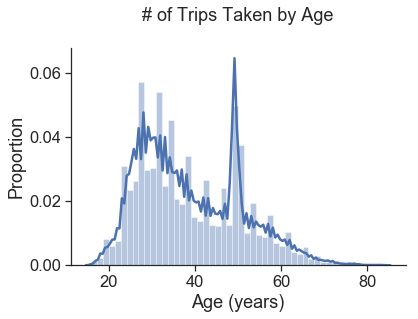

In [15]:
# Plot 
a = sns.distplot(trips_all['age'])
a.set(title = '# of Trips Taken by Age\n ')
a.set(xlabel = 'Age (years)')
a.set(ylabel = 'Proportion')
sns.despine()

The distribution of age peaks at around 30 years of age and has a long right tail. There is a strange increase in the number of riders at age 50. I am guessing this is because that is the default year provided when signing up for the program. Moving forward any analysis with age should be interpereted with a grain of salt since a small proportion of riders misattribute their age.

### Gender

Investigate how ridership breaks down by gender

In [59]:
# Label genders
gender_dict = {0:'Unknown', 1:'Male', 2:'Female'}
trips_all['gender'] = trips_all['gender'].replace(gender_dict)

# Count # trips per gender
trip_counts = trips_all.groupby('gender').size().reset_index(name='counts')
trip_counts['counts'] = trip_counts['counts']/100000 #rescale to plot in millions

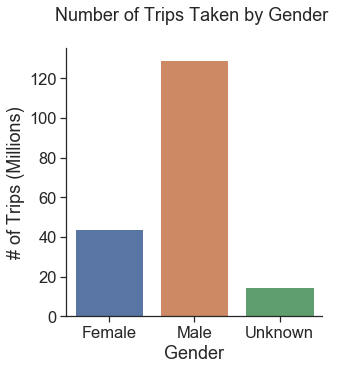

In [64]:
a = sns.catplot('gender', y='counts', kind = 'bar', data = trip_counts, legend = True)
a.set(title = 'Number of Trips Taken by Gender \n ')
a.set(xlabel = 'Gender')
a.set(ylabel = '# of Trips (Millions)')

A large majority of rides are taken by male riders. Does this trend hold for all age brackets or are there more female rides taken for younger riders?

In [75]:
# % of rides for each gender for each of 5 age bins
gender_age_bracket = pd.crosstab(trips_all['gender'],trips_all['ageband'], normalize= 'columns').unstack().reset_index()

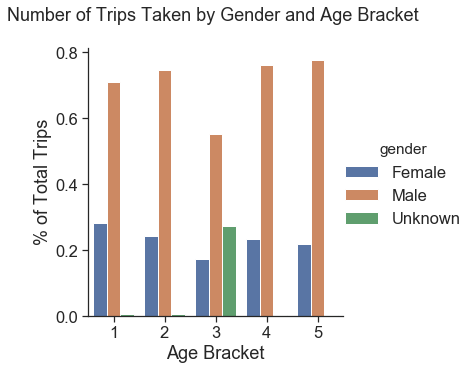

In [76]:
a = sns.catplot('ageband', y=0, hue = 'gender',kind = 'bar', data = gender_age_bracket , legend = True)
a.set(title = 'Number of Trips Taken by Gender and Age Bracket \n ')
a.set(xlabel = 'Age Bracket')
a.set(ylabel = '% of Total Trips')

There seems to be an anomoly in the data where most unkown riders fall into the middle age bracket. These are probably the same riders who submitted the default demographic parameters that caused the increase in riders at age 50 seen above. To check for the coincidence between the default age and unkown gender ridership lets plot the % of unkown riders for each age. 

In [78]:
# Number of rides for each gender for each age
gender_age = pd.crosstab(trips_all['gender'],trips_all['age']).unstack().reset_index()
gender_age_unknown = gender_age.loc[gender_age['gender'] == 'Unknown']
gender_age_unknown[0] = gender_age_unknown[0]/100000 #rescale to plot in millions

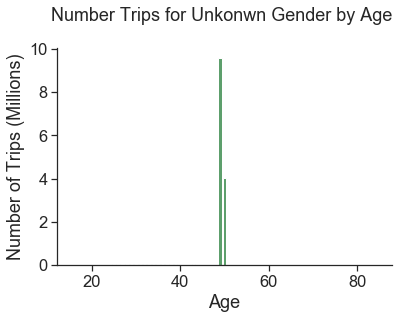

In [110]:
fig, ax = plt.subplots()
plt.bar(gender_age_unknown['age'], gender_age_unknown[0], color = "#5D9F6C")
ax.set_title('Number Trips for Unkonwn Gender by Age \n ')
ax.set(xlabel = 'Age')
ax.set(ylabel = 'Number of Trips (Millions)')
sns.despine()

Indeed, almost all of the trips taken by Unknown gender riders were at the age of 50. Thus it is extremely likely that these were riders that just submitted the defualt demographics. I will exclude the unknown gender riders and update the graph of gender x age bracket accordingly. 

In [114]:
trips_all_mf = trips_all.loc[trips_all['gender'].isin(['Male', 'Female'])]
gender_age_bracket = pd.crosstab(trips_all_mf['gender'],trips_all_mf['ageband'], normalize= 'columns').unstack().reset_index()

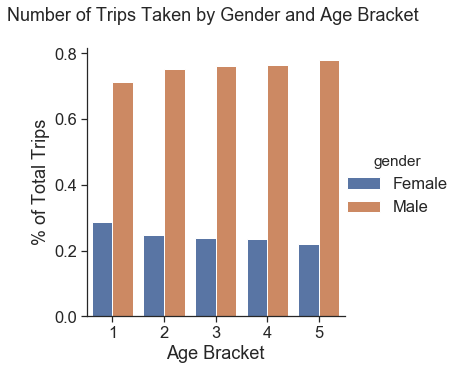

In [115]:
a = sns.catplot('ageband', y=0, hue = 'gender',kind = 'bar', data = gender_age_bracket , legend = True)
a.set(title = 'Number of Trips Taken by Gender and Age Bracket \n ')
a.set(xlabel = 'Age Bracket')
a.set(ylabel = '% of Total Trips')

There seems to be a weak trens where the younger age brackets (at least the very youngest bracket) has a larger proportion of female riders. But overall there is a large majority of male riders in each bracket. 

## Temporal patterns

### Usage over the year

In [132]:
# Number of trips per day of the year
trips_all.index = trips_all['starttime']
day_trips_count = trips_all.starttime.resample('D', how = ['count'])

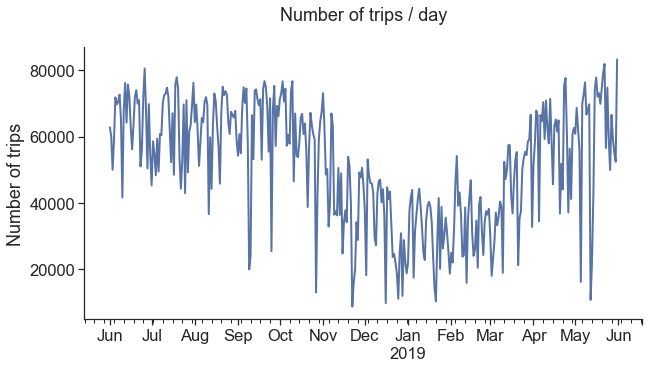

In [141]:
day_trips_count.plot(stacked = False, figsize = (10, 5),
                  color = '#5874A6', linewidth = 2, legend = False)
plt.title('Number of trips / day\n')
plt.xlabel('')
plt.ylabel('Number of trips')
sns.despine()

The number of trips declines in the winter months with local flucations in ridership reflecting decreased rides on weekends on holidays.

## Time of day

In [154]:
hour_trips_count = trips_all.groupby(['starthour','weekend']).size().reset_index(name='counts')

weekend_dict = {0: 'weekday', 1: 'weekend'}
hour_trips_count['weekend'] = hour_trips_count['weekend'].replace(weekend_dict)
hour_trips_count['counts']  =hour_trips_count['counts']/100000

In [160]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

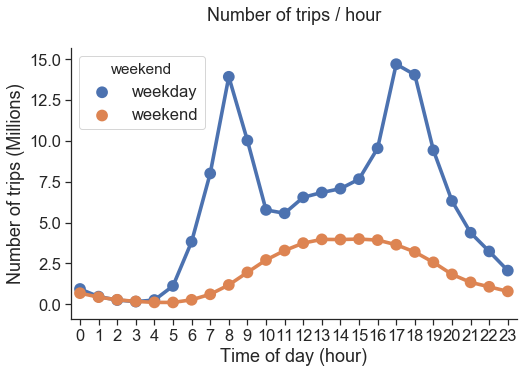

In [162]:
a = sns.pointplot('starthour',y = 'counts', hue ='weekend', kind='point',sharey= False, data =hour_trips_count)
plt.title('Number of trips / hour\n')
plt.xlabel('Time of day (hour)')
plt.ylabel('Number of trips (Millions)')
sns.despine()

On weekdays there is a bimodal distrubtion of trips with peaks during rush hour commute times. On the weekend, rides typically occur during the mid hours of the day. 

## Time within hour

In [185]:
minute_trips_count = trips_all.groupby('startminute').size().reset_index(name='counts')
minute_trips_count['counts'] = minute_trips_count['counts']/100000

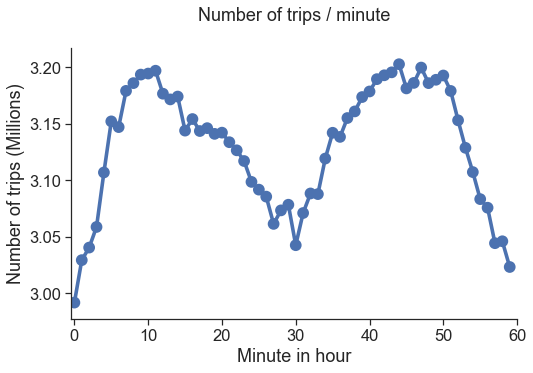

In [189]:
a = sns.pointplot('startminute',y = 'counts', kind='point',sharey= False, data =minute_trips_count)
a.set(title=('Number of trips / minute\n'))
a.set(xlabel=('Minute in hour'))
a.set(ylabel=('Number of trips (Millions)'))
a.set(xticks=[0,10,20,30,40,50,60])
a.set(xticklabels=[0,10,20,30,40,50,60])
sns.despine()

Interestingly there is also a bimodal distribution for the time within an hour when citibikes are most used. There are peaks about 10 minutes after the hour starts and 10 minutes before the hour starts. 

## Create Maps

Now lets create a function that draws the most popular routes for a given dataset. The function will take a parameter that controls the number of routes displayed. Before we create the function we have to create sub functions to help with data orginzation and plotting. Note: for these maps we will be excluding trips taken to and from the same station.

In [190]:
## Create table of station lat and long for start and end stations
start_stations = trips_all.loc[:,['start station name', 'start station id', 'start station latitude', 'start station longitude']]
start_stations.index = start_stations['start station name']
start_stations = start_stations.drop_duplicates()

end_stations = trips_all.loc[:,['end station name', 'end station id', 'end station latitude', 'end station longitude']]
end_stations.index = end_stations['end station name']
end_stations = end_stations.drop_duplicates()

In [191]:
def most_popular_routes(df,num_routes,start_stations,end_stations):
    
    '''
    Return a DataFrame with the top N number of routes
    
    Parameters
    df : DataFrame of trips
    num_routes : top N number of routes to return
    start_stations : table of start stations name, latitude, and longitude
    end_stations : table of start stations name, latitude, and longitude
    
    Return
    DataFrame of top N routes including start station, end stations, and count number
    '''
    
    
    # count number of trips for every station combination
    df = pd.crosstab(df['start station name'],df['end station name']).unstack().reset_index().rename(columns= {0:'count'})
    
    # do not include trips to and from same station
    df = df[df['end station name'] != df['start station name']]
    
    # get top n number of routes 
    df_top = df.nlargest(num_routes, 'count')
    
    df_top = df_top.merge(start_stations)
    df_top = df_top.merge(end_stations)
    
    return df_top
    

In [192]:
def get_arrows(locations, color='blue', size=3, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [193]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

In [194]:
def create_map(df,start_stations,end_stations,num_routes=10):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    folium map 
    
    '''
    # get top n stations for df provided
    df_n = most_popular_routes(df,num_routes,start_stations,end_stations)
    
    min_count = df_n['count'].min()
    #norm = Normalize(df_n['count'].min(), df_n['count'].max())
    
    # draw map
    tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
    station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

    for index, row in df_n.iterrows():
    
        folium.CircleMarker(location = [row['start station latitude'],
                                              row['start station longitude']],
                                  popup = row['start station name'],
                        radius= 2.5, color = ['#888888'], fill_color = ['#888888'],line_color = ['#888888'],
                            opacity=[1]).add_to(station_map)
        
        folium.CircleMarker(location = [row['end station latitude'],
                                              row['end station longitude']],
                                  popup = row['end station name'],
                              radius = 2.5, color = ['#888888'],  fill_color = ['#888888'],line_color = ['#888888'],
                            opacity=[1]).add_to(station_map)
    
        p1 = [row['start station latitude'],row['start station longitude']]
        p2 = [row['end station latitude'],row['end station longitude']]
        
        #color = rgb2hex(cm.YlOrRd(norm(row['count'])))
    
        folium.PolyLine(locations = [p1,p2], weight = row['count']/(min_count/4),
                        popup =  row['count'],
                        color = ['#5DADE2'],opacity=[.6]).add_to(station_map)
    
        arrows = get_arrows(locations=[p1, p2], color = ['#1A5276'],  n_arrows=1)
    
        for arrow in arrows:
            arrow.add_to(station_map)
            
    
    return station_map    

    

### All trips

In [195]:
create_map(trips_all,start_stations,end_stations,10)

### Weekend vs Weekday

In [196]:
trips_weekday = trips_all[trips_all['weekend'] == 0]
trips_weekend = trips_all[trips_all['weekend'] == 1]

#### Weekday

In [197]:
create_map(trips_weekday,start_stations,end_stations,10)

#### Weekend

In [198]:
create_map(trips_weekend,start_stations,end_stations,10)

The most popular use for Citibike during the week seems to be short rides to popular subway stations, whereas during the weekends trips are leisurlely rides along the hudson river, governers island and central park. 